In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [3]:
train_data_dir = 'category_train'
categories = os.listdir(train_data_dir)
print(categories)

['Bottoms', 'Shoes', 'Tops']


In [4]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


3
{'Bottoms': 0, 'Shoes': 1, 'Tops': 2}
{0: 'Bottoms', 1: 'Shoes', 2: 'Tops'}


In [5]:
def random_pick() -> tuple[np.ndarray, int]:
    category = random.choice(categories)
    img_fnames = os.listdir(f'{train_data_dir}/{category}')
    img_path = f'{train_data_dir}/{category}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = category_to_label[category]
    return img, label

image_shape=(900, 720, 3)


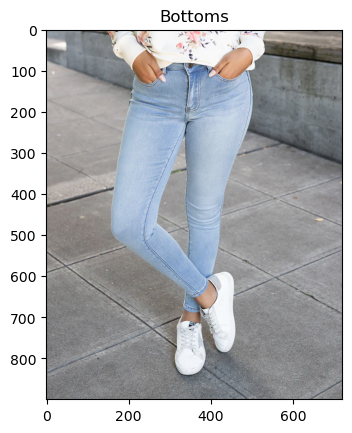

In [6]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_category[label])
plt.show()

In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [9]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
dataset = ImageDataset(ImageLoader())

 33%|███▎      | 1/3 [00:00<00:01,  1.90it/s]d:\Anaconda\envs\dev\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


In [11]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [12]:
val_ratio = 0.2
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [13]:
len(dataset)

565

In [14]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 422, val: 113, test: 30


In [15]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [16]:
import torch.nn as nn

In [17]:
class CategoryClassifier(nn.Module):
    def __init__(self):
        super(CategoryClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.output = nn.Sequential(
            nn.Linear(256, num_labels)
        )


        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)

        return x

In [18]:
model = CategoryClassifier().to(device)

In [19]:
from torchsummary import summary

summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [21]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [22]:
epochs = 100

#scheduler = StepLR(optimizer, step_size = 150, gamma = 0.1) # decrease epoch by 0.1 every 50 steps

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)

    #scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


epoch=1, train_loss=0.782, val_loss=0.957, train_accuracy=0.588, val_accuracy=0.673


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


epoch=2, train_loss=0.655, val_loss=0.973, train_accuracy=0.656, val_accuracy=0.673


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


epoch=3, train_loss=0.603, val_loss=0.922, train_accuracy=0.659, val_accuracy=0.673


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


epoch=4, train_loss=0.558, val_loss=0.916, train_accuracy=0.692, val_accuracy=0.611


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


epoch=5, train_loss=0.533, val_loss=0.884, train_accuracy=0.756, val_accuracy=0.575


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


epoch=6, train_loss=0.491, val_loss=0.861, train_accuracy=0.782, val_accuracy=0.549


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


epoch=7, train_loss=0.491, val_loss=0.798, train_accuracy=0.796, val_accuracy=0.584


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


epoch=8, train_loss=0.438, val_loss=0.799, train_accuracy=0.832, val_accuracy=0.566


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


epoch=9, train_loss=0.439, val_loss=0.690, train_accuracy=0.808, val_accuracy=0.611


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


epoch=10, train_loss=0.391, val_loss=0.608, train_accuracy=0.827, val_accuracy=0.699


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


epoch=11, train_loss=0.376, val_loss=0.652, train_accuracy=0.829, val_accuracy=0.673


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


epoch=12, train_loss=0.321, val_loss=0.614, train_accuracy=0.863, val_accuracy=0.726


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


epoch=13, train_loss=0.318, val_loss=0.611, train_accuracy=0.855, val_accuracy=0.708


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


epoch=14, train_loss=0.310, val_loss=0.547, train_accuracy=0.867, val_accuracy=0.779


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


epoch=15, train_loss=0.317, val_loss=0.536, train_accuracy=0.879, val_accuracy=0.779


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


epoch=16, train_loss=0.249, val_loss=0.536, train_accuracy=0.886, val_accuracy=0.770


100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


epoch=17, train_loss=0.265, val_loss=0.465, train_accuracy=0.872, val_accuracy=0.805


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


epoch=18, train_loss=0.264, val_loss=0.506, train_accuracy=0.886, val_accuracy=0.788


100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


epoch=19, train_loss=0.249, val_loss=0.413, train_accuracy=0.896, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


epoch=20, train_loss=0.293, val_loss=0.380, train_accuracy=0.898, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


epoch=21, train_loss=0.279, val_loss=0.519, train_accuracy=0.889, val_accuracy=0.788


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


epoch=22, train_loss=0.281, val_loss=0.625, train_accuracy=0.886, val_accuracy=0.717


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


epoch=23, train_loss=0.232, val_loss=0.445, train_accuracy=0.908, val_accuracy=0.814


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


epoch=24, train_loss=0.215, val_loss=0.320, train_accuracy=0.912, val_accuracy=0.876


100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


epoch=25, train_loss=0.214, val_loss=0.330, train_accuracy=0.915, val_accuracy=0.876


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


epoch=26, train_loss=0.216, val_loss=0.350, train_accuracy=0.922, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


epoch=27, train_loss=0.275, val_loss=0.383, train_accuracy=0.924, val_accuracy=0.823


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


epoch=28, train_loss=0.173, val_loss=0.403, train_accuracy=0.936, val_accuracy=0.814


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


epoch=29, train_loss=0.210, val_loss=0.347, train_accuracy=0.910, val_accuracy=0.858


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


epoch=30, train_loss=0.156, val_loss=0.191, train_accuracy=0.943, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


epoch=31, train_loss=0.188, val_loss=0.181, train_accuracy=0.924, val_accuracy=0.956


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


epoch=32, train_loss=0.154, val_loss=0.264, train_accuracy=0.931, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


epoch=33, train_loss=0.167, val_loss=0.339, train_accuracy=0.938, val_accuracy=0.858


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


epoch=34, train_loss=0.172, val_loss=0.333, train_accuracy=0.945, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


epoch=35, train_loss=0.159, val_loss=0.191, train_accuracy=0.948, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


epoch=36, train_loss=0.131, val_loss=0.209, train_accuracy=0.941, val_accuracy=0.894


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


epoch=37, train_loss=0.139, val_loss=0.269, train_accuracy=0.950, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


epoch=38, train_loss=0.109, val_loss=0.255, train_accuracy=0.948, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


epoch=39, train_loss=0.160, val_loss=0.200, train_accuracy=0.943, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


epoch=40, train_loss=0.132, val_loss=0.215, train_accuracy=0.972, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


epoch=41, train_loss=0.203, val_loss=0.176, train_accuracy=0.919, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


epoch=42, train_loss=0.151, val_loss=0.381, train_accuracy=0.945, val_accuracy=0.858


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


epoch=43, train_loss=0.177, val_loss=0.305, train_accuracy=0.912, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


epoch=44, train_loss=0.144, val_loss=0.290, train_accuracy=0.953, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


epoch=45, train_loss=0.115, val_loss=0.315, train_accuracy=0.955, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


epoch=46, train_loss=0.121, val_loss=0.297, train_accuracy=0.948, val_accuracy=0.894


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


epoch=47, train_loss=0.109, val_loss=0.316, train_accuracy=0.957, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


epoch=48, train_loss=0.119, val_loss=0.306, train_accuracy=0.962, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


epoch=49, train_loss=0.120, val_loss=0.256, train_accuracy=0.962, val_accuracy=0.894


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


epoch=50, train_loss=0.114, val_loss=0.275, train_accuracy=0.962, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


epoch=51, train_loss=0.068, val_loss=0.321, train_accuracy=0.981, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


epoch=52, train_loss=0.102, val_loss=0.336, train_accuracy=0.960, val_accuracy=0.876


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


epoch=53, train_loss=0.088, val_loss=0.310, train_accuracy=0.979, val_accuracy=0.867


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


epoch=54, train_loss=0.085, val_loss=0.285, train_accuracy=0.976, val_accuracy=0.858


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


epoch=55, train_loss=0.076, val_loss=0.287, train_accuracy=0.967, val_accuracy=0.876


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


epoch=56, train_loss=0.079, val_loss=0.251, train_accuracy=0.972, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


epoch=57, train_loss=0.066, val_loss=0.188, train_accuracy=0.976, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


epoch=58, train_loss=0.057, val_loss=0.178, train_accuracy=0.981, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


epoch=59, train_loss=0.082, val_loss=0.151, train_accuracy=0.967, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


epoch=60, train_loss=0.049, val_loss=0.154, train_accuracy=0.988, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


epoch=61, train_loss=0.082, val_loss=0.167, train_accuracy=0.969, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


epoch=62, train_loss=0.059, val_loss=0.131, train_accuracy=0.988, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


epoch=63, train_loss=0.101, val_loss=0.153, train_accuracy=0.969, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


epoch=64, train_loss=0.116, val_loss=0.113, train_accuracy=0.967, val_accuracy=0.973


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


epoch=65, train_loss=0.078, val_loss=0.141, train_accuracy=0.974, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


epoch=66, train_loss=0.067, val_loss=0.194, train_accuracy=0.974, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


epoch=67, train_loss=0.069, val_loss=0.126, train_accuracy=0.979, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


epoch=68, train_loss=0.069, val_loss=0.125, train_accuracy=0.981, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


epoch=69, train_loss=0.060, val_loss=0.188, train_accuracy=0.981, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


epoch=70, train_loss=0.049, val_loss=0.229, train_accuracy=0.981, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


epoch=71, train_loss=0.057, val_loss=0.214, train_accuracy=0.979, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


epoch=72, train_loss=0.049, val_loss=0.254, train_accuracy=0.981, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


epoch=73, train_loss=0.033, val_loss=0.262, train_accuracy=0.986, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


epoch=74, train_loss=0.026, val_loss=0.224, train_accuracy=0.993, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


epoch=75, train_loss=0.065, val_loss=0.172, train_accuracy=0.972, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


epoch=76, train_loss=0.041, val_loss=0.134, train_accuracy=0.983, val_accuracy=0.947


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


epoch=77, train_loss=0.061, val_loss=0.180, train_accuracy=0.974, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


epoch=78, train_loss=0.031, val_loss=0.194, train_accuracy=0.991, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


epoch=79, train_loss=0.050, val_loss=0.204, train_accuracy=0.979, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


epoch=80, train_loss=0.027, val_loss=0.174, train_accuracy=0.986, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


epoch=81, train_loss=0.064, val_loss=0.152, train_accuracy=0.986, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


epoch=82, train_loss=0.051, val_loss=0.190, train_accuracy=0.986, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


epoch=83, train_loss=0.074, val_loss=0.247, train_accuracy=0.976, val_accuracy=0.894


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


epoch=84, train_loss=0.038, val_loss=0.235, train_accuracy=0.979, val_accuracy=0.885


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


epoch=85, train_loss=0.027, val_loss=0.230, train_accuracy=0.993, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


epoch=86, train_loss=0.036, val_loss=0.229, train_accuracy=0.986, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


epoch=87, train_loss=0.060, val_loss=0.236, train_accuracy=0.983, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


epoch=88, train_loss=0.060, val_loss=0.188, train_accuracy=0.976, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


epoch=89, train_loss=0.077, val_loss=0.192, train_accuracy=0.976, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


epoch=90, train_loss=0.037, val_loss=0.207, train_accuracy=0.983, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


epoch=91, train_loss=0.059, val_loss=0.220, train_accuracy=0.979, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


epoch=92, train_loss=0.044, val_loss=0.223, train_accuracy=0.983, val_accuracy=0.903


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


epoch=93, train_loss=0.038, val_loss=0.225, train_accuracy=0.986, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


epoch=94, train_loss=0.043, val_loss=0.160, train_accuracy=0.981, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


epoch=95, train_loss=0.040, val_loss=0.128, train_accuracy=0.991, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


epoch=96, train_loss=0.073, val_loss=0.121, train_accuracy=0.979, val_accuracy=0.929


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


epoch=97, train_loss=0.023, val_loss=0.136, train_accuracy=0.993, val_accuracy=0.938


100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


epoch=98, train_loss=0.029, val_loss=0.190, train_accuracy=0.986, val_accuracy=0.920


100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


epoch=99, train_loss=0.045, val_loss=0.193, train_accuracy=0.986, val_accuracy=0.912


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


epoch=100, train_loss=0.068, val_loss=0.190, train_accuracy=0.972, val_accuracy=0.929


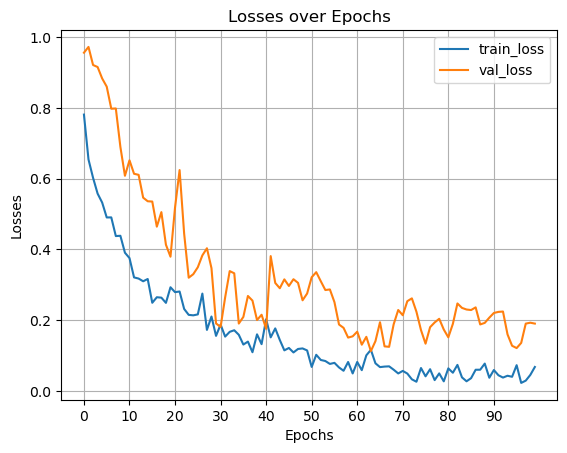

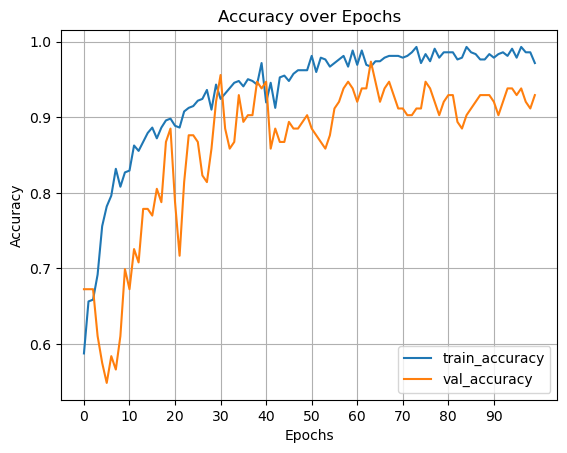

In [23]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [24]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [25]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Category: {label_to_category[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_category[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_category[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

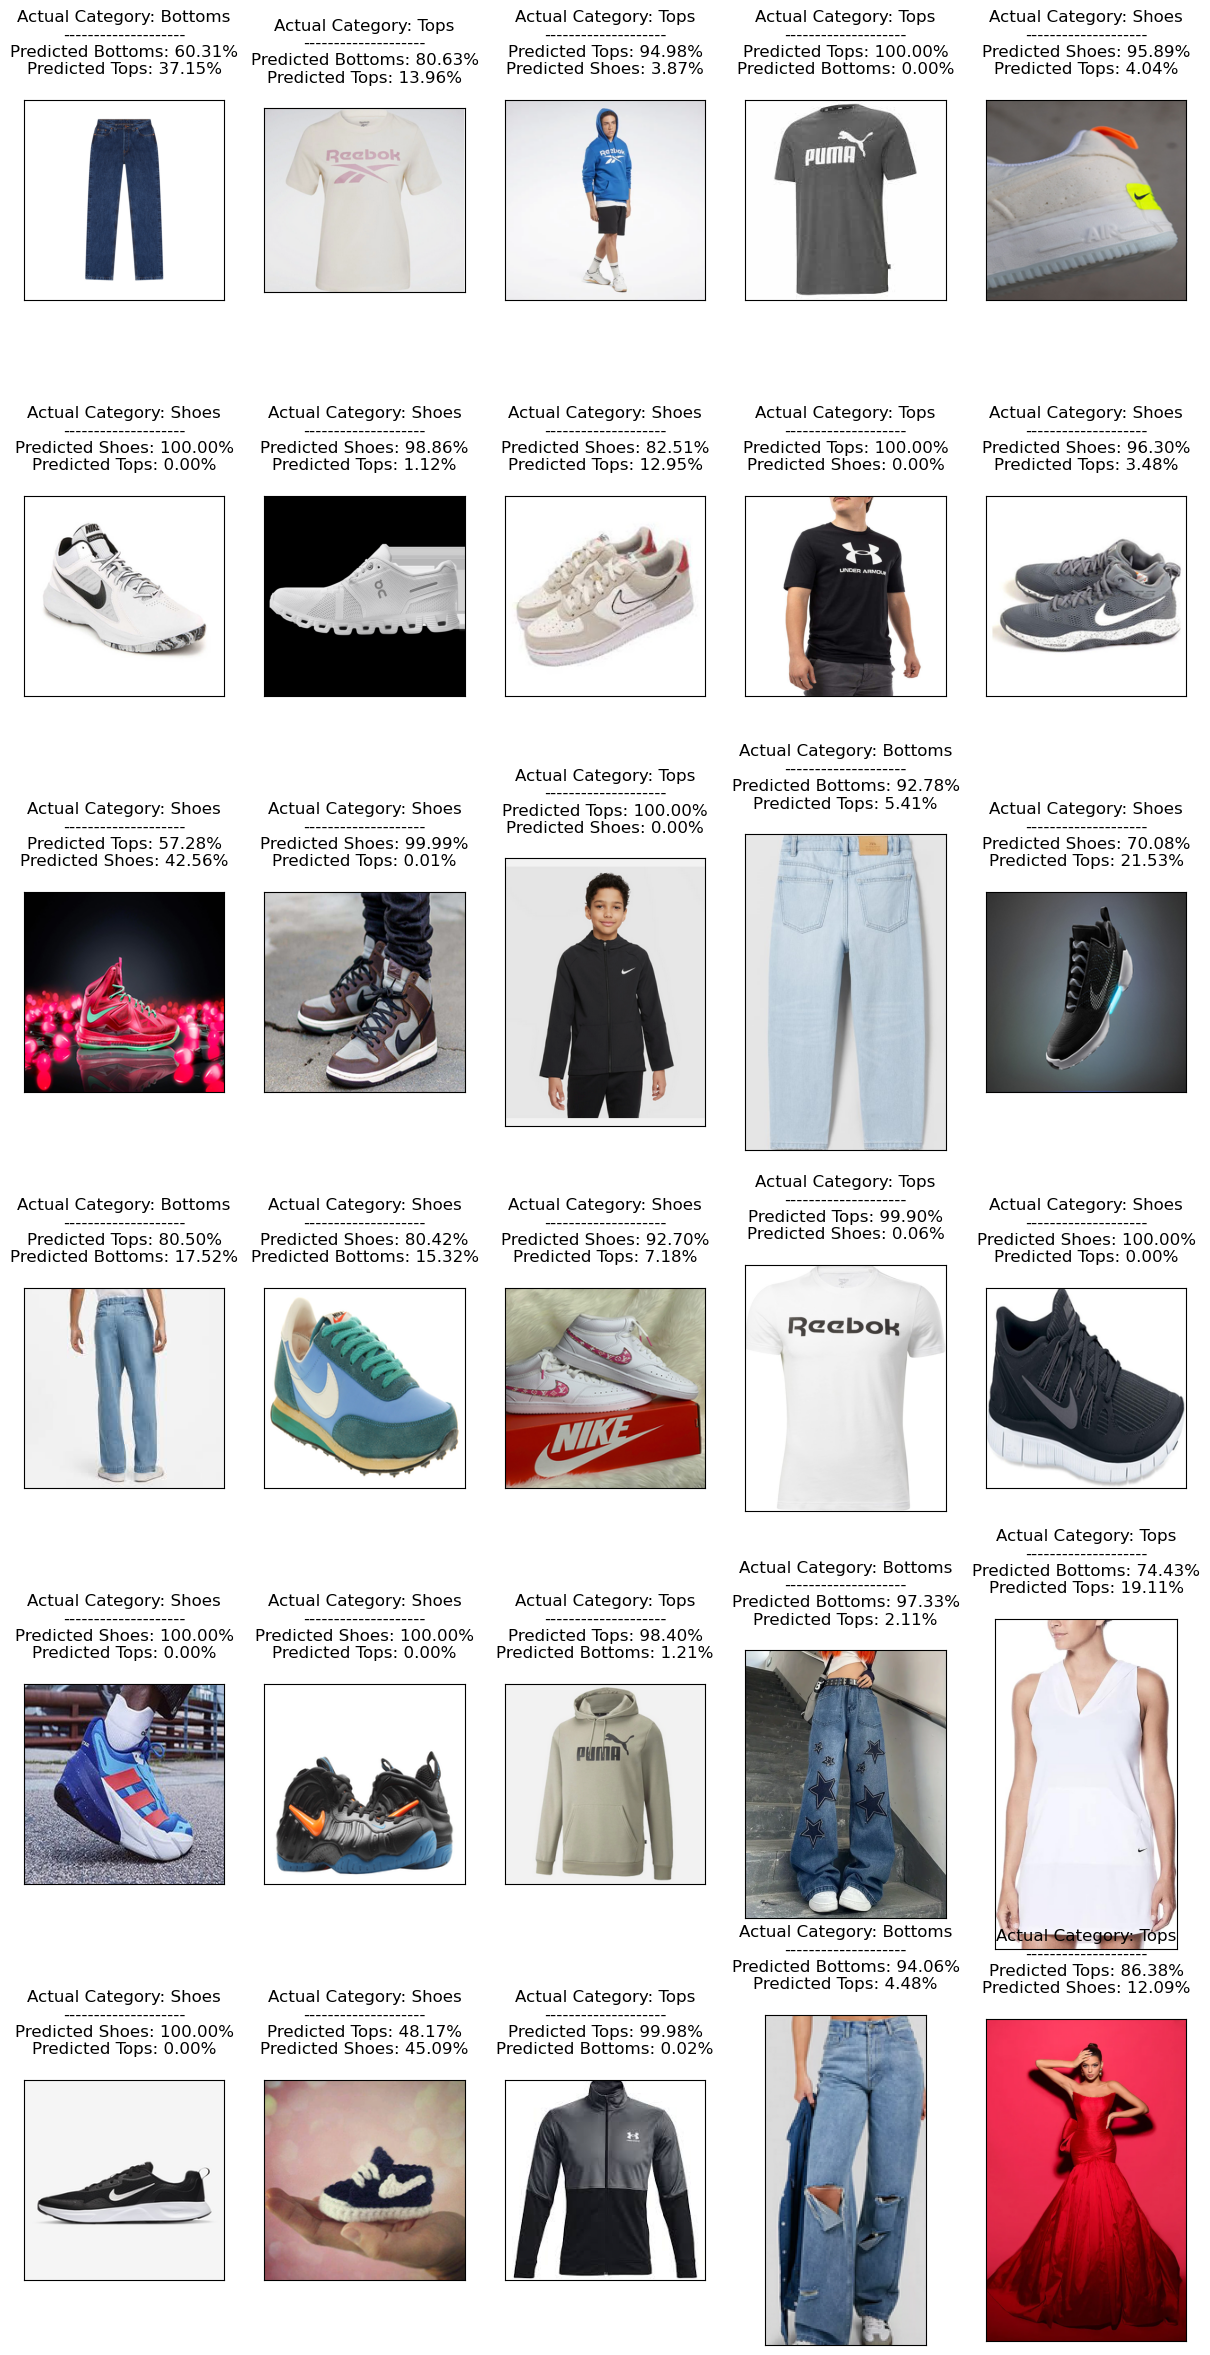

In [26]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)